In [ ]:
import pandas as pd

df = pd.read_csv("/content/sample_data/feds200628.csv", skiprows=9, parse_dates=["Date"])
df = df[df["Date"] >= "1990-01-01"].copy()
yield_cols = [col for col in df.columns if col.startswith("SVENY")]
df = df.dropna(subset=yield_cols)
df = df[["Date", "SVENY02", "SVENY05", "SVENY10", "SVENY20", "SVENY30"]]
df.columns = ["Date", "2y", "5y", "10y", "20y", "30y"]
df.set_index("Date", inplace=True)


In [ ]:
import numpy as np
from numpy.linalg import lstsq
import pandas as pd

maturities = np.array([2, 5, 10, 20, 30])
lambda_ns = 0.0609

def ns_loadings(tau, lam):
    l1 = (1 - np.exp(-lam * tau)) / (lam * tau)
    l2 = l1 - np.exp(-lam * tau)
    return np.column_stack((np.ones_like(tau), l1, l2))

X = ns_loadings(maturities, lambda_ns)
factors = []

for _, row in df.iterrows():
    y = row.values
    beta, _, _, _ = lstsq(X, y, rcond=None)
    factors.append(beta)

factors_df = pd.DataFrame(factors, columns=["Level", "Slope", "Curvature"], index=df.index)


In [ ]:
import pymc as pm

window = 8000
slope = factors_df['Slope'].values[:window]
slope_mean = slope.mean()
slope_std = slope.std()
f_t = (slope - slope_mean) / slope_std

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    phi = pm.Normal('phi', mu=0.95, sigma=0.1)

    delta = pm.Normal('delta', mu=0.98, sigma=0.05)
    sigma_v = pm.HalfNormal('sigma_v', sigma=0.5)
    nu = pm.Normal('nu', mu=0, sigma=1, shape=window)

    h_vals = [pm.Normal('h_0', mu=0, sigma=0.1)]
    for t in range(1, window):
        h_t = delta * h_vals[-1] + sigma_v * nu[t]
        h_vals.append(h_t)
    h = pm.Deterministic('h', pm.math.stack(h_vals))

    p_jump = pm.Beta('p_jump', alpha=2, beta=10)
    delta_n = pm.Bernoulli('jump_indicator', p=p_jump, shape=window)
    mu_j = pm.Normal('mu_j', mu=0, sigma=1)
    sigma_j = pm.HalfNormal('sigma_j', sigma=1)
    j_t = pm.Normal('jump_size', mu=mu_j, sigma=sigma_j, shape=window)

    eps = pm.Normal('eps', mu=0, sigma=1, shape=window)
    volatility = pm.Deterministic('volatility', pm.math.exp(h / 2))
    shocks = pm.Deterministic('shocks', j_t * delta_n + volatility * eps)

    f_tm1 = np.roll(f_t, 1)
    f_tm1[0] = f_t[0]
    f_pred = pm.Deterministic('f_pred', mu + phi * f_tm1)

    obs = pm.Normal('obs', mu=f_pred + shocks, sigma=1e-4, observed=f_t)

    trace = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.95,
        init='adapt_diag',
        return_inferencedata=True
    )

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Mean posterior probability of jump per day
jump_probs = trace.posterior['jump_indicator'].mean(dim=("chain", "draw")).values

plt.figure(figsize=(12, 4))
plt.plot(jump_probs, label="Posterior Jump Probability")
plt.title("Estimated Daily Jump Probability (Slope Factor)")
plt.xlabel("Day")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Median posterior volatility
vol_path = trace.posterior['volatility'].median(dim=("chain", "draw")).values

plt.figure(figsize=(12, 4))
plt.plot(vol_path, label="Estimated Volatility", color='darkorange')
plt.title("Estimated Daily Volatility (Slope Factor)")
plt.xlabel("Day")
plt.ylabel("Volatility")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Posterior median predictions
f_pred = trace.posterior['f_pred'].median(dim=("chain", "draw")).values
shocks = trace.posterior['shocks'].median(dim=("chain", "draw")).values
fitted = f_pred + shocks

plt.figure(figsize=(12, 4))
plt.plot(f_t, label='Observed Slope', alpha=0.6)
plt.plot(fitted, label='Model Fit', linestyle='--', linewidth=2)
plt.title("Observed vs. Fitted Slope Factor")
plt.xlabel("Day")
plt.ylabel("Value (Centered)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Now modelling slope curvature and levels


In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import arviz as az
import matplotlib.pyplot as plt

df = pd.read_csv("/content/sample_data/feds200628.csv", skiprows=9, parse_dates=["Date"])
df = df[df["Date"] >= "1990-01-01"].dropna(subset=["BETA0", "BETA1", "BETA2"])
df.set_index("Date", inplace=True)
df = df.rename(columns={"BETA0": "Level", "BETA1": "Slope", "BETA2": "Curvature"})
factors_df = df[["Level", "Slope", "Curvature"]].copy()
factors_centered = factors_df - factors_df.mean()

window = 100
f_data = factors_centered.values[:window].T

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1, shape=3)
    phi = pm.Normal("phi", mu=0.95, sigma=0.1, shape=3)

    delta = pm.Normal("delta", mu=0.98, sigma=0.05, shape=3)
    sigma_v = pm.HalfNormal("sigma_v", sigma=0.5, shape=3)
    nu = pm.Normal("nu", mu=0, sigma=1, shape=(3, window))

    h_vals = []
    for i in range(3):
        h0_i = pm.Normal(f"h0_{i}", mu=0, sigma=0.1)
        def step_h(nu_t, h_tm1, delta_i, sigma_v_i):
            return delta_i * h_tm1 + sigma_v_i * nu_t

        h_i, _ = pytensor.scan(
            fn=step_h,
            sequences=nu[i, 1:],
            outputs_info=[h0_i],
            non_sequences=[delta[i], sigma_v[i]],
        )
        h_full = pm.math.concatenate([[h0_i], h_i])
        h_vals.append(h_full)

    h = pm.Deterministic("h", pm.math.stack(h_vals))
    volatility = pm.Deterministic("volatility", pm.math.exp(h / 2))

    p_jump = pm.Beta("p_jump", alpha=2, beta=10, shape=3)
    delta_n = pm.Bernoulli("jump_indicator", p=p_jump[:, None], shape=(3, window))
    mu_j = pm.Normal("mu_j", mu=0, sigma=1, shape=3)
    sigma_j = pm.HalfNormal("sigma_j", sigma=1, shape=3)
    j_t = pm.Normal("jump_size", mu=mu_j[:, None], sigma=sigma_j[:, None], shape=(3, window))

    eps = pm.Normal("eps", mu=0, sigma=1, shape=(3, window))
    shocks = pm.Deterministic("shocks", j_t * delta_n + volatility * eps)

    f_tm1 = np.roll(f_data, shift=1, axis=1)
    f_tm1[:, 0] = f_data[:, 0]
    f_pred = pm.Deterministic("f_pred", mu[:, None] + phi[:, None] * f_tm1)

    obs = pm.Normal("obs", mu=f_pred + shocks, sigma=1e-4, observed=f_data)

    _ = model.logp()

    trace = pm.sample(
        draws=500,
        tune=500,
        target_accept=0.95,
        init="jitter+adapt_diag",
        chains=2,
        cores=1,
        return_inferencedata=True
    )

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   1000    0             0.000       31           2.73 draws/s     0:06:05   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   1000    0             0.000       31           1.27 draws/s     0:13:09   0:00:00

/usr/local/lib/python3.12/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


✅ Sampling complete!


In [ ]:
import arviz as az
import matplotlib.pyplot as plt

az.plot_trace(trace, var_names=["mu", "phi", "delta", "sigma_v", "p_jump", "mu_j", "sigma_j"], figsize=(14, 10))
plt.tight_layout()
plt.show()

summary = az.summary(trace, var_names=["mu", "phi", "delta", "sigma_v", "p_jump", "mu_j", "sigma_j"])
print(summary)

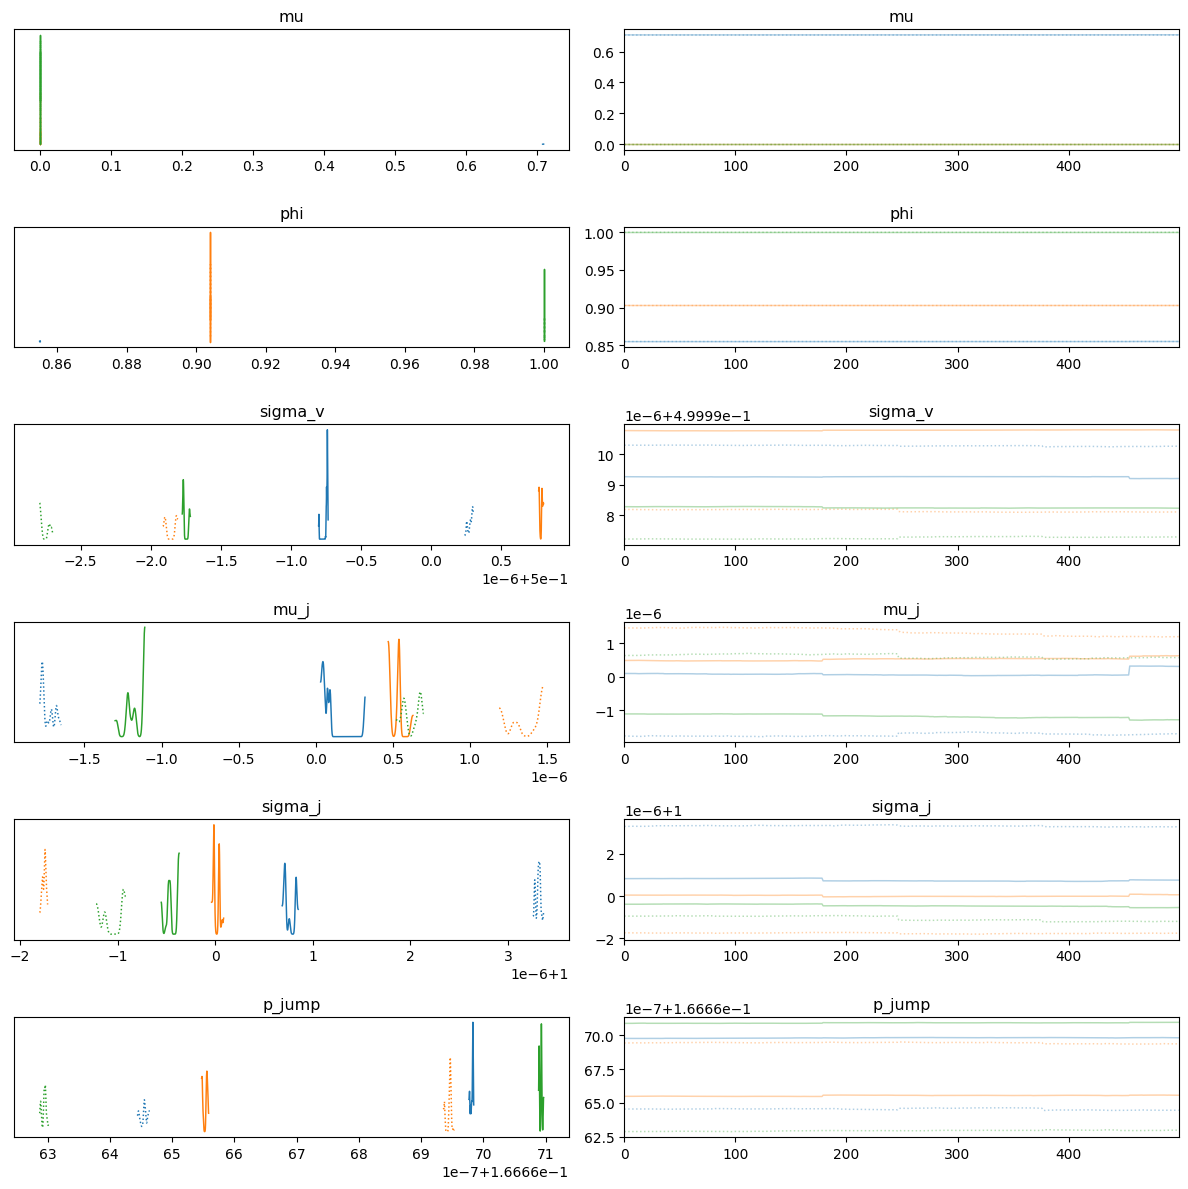

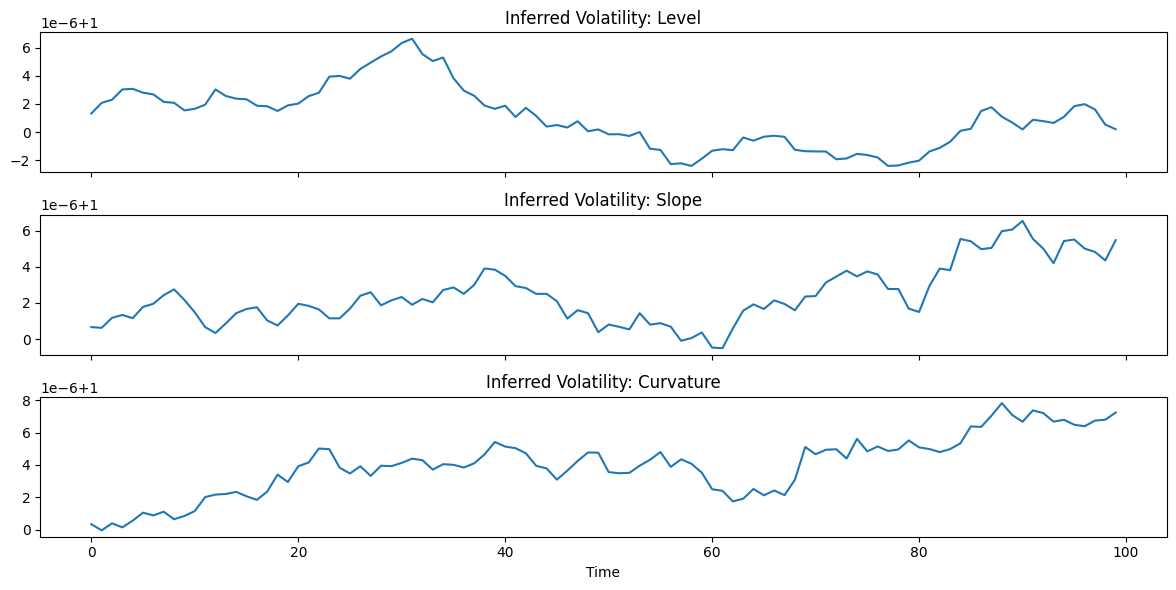

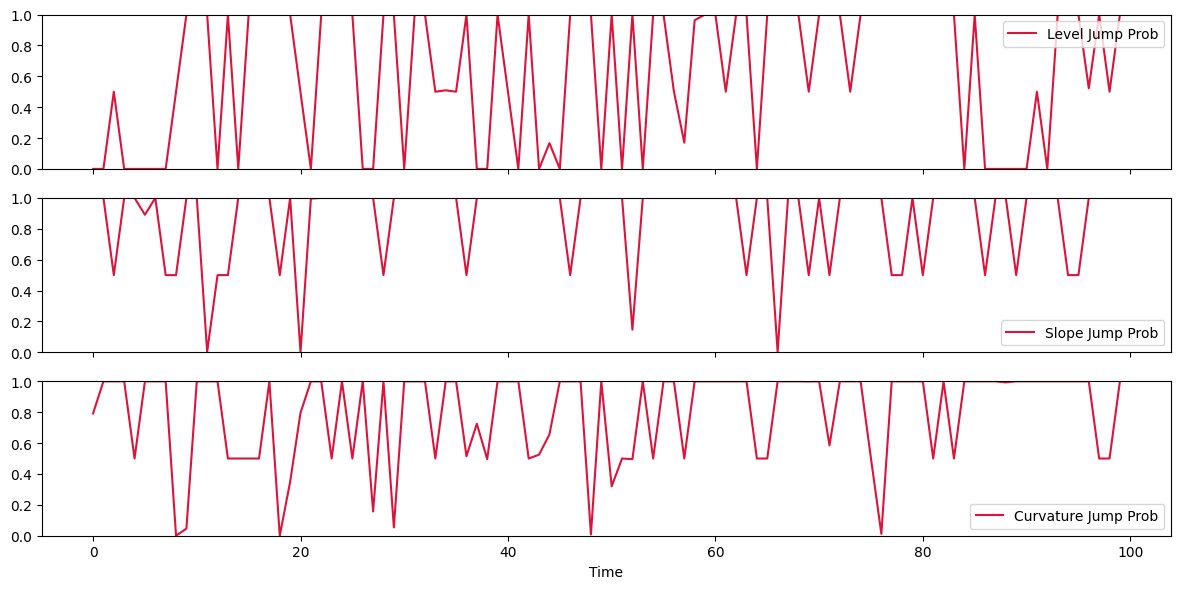

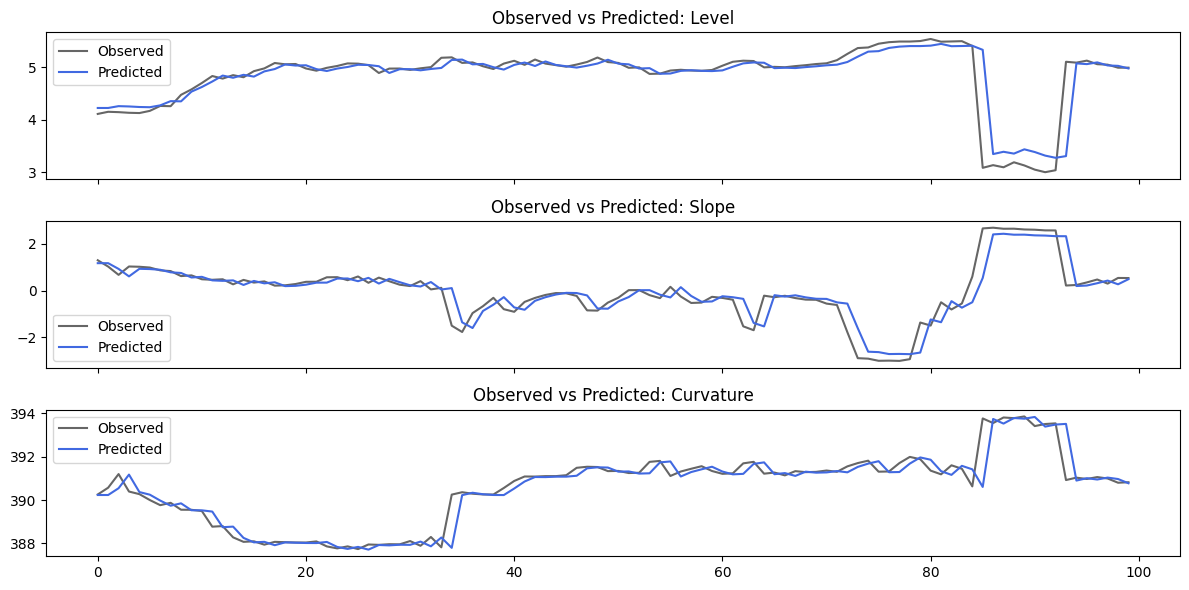

In [ ]:
# 1. Basic trace plots
az.plot_trace(trace, var_names=["mu", "phi", "sigma_v", "mu_j", "sigma_j", "p_jump"])
plt.tight_layout()
plt.show()

# 2. Volatility paths
import seaborn as sns
h_samples = trace.posterior["volatility"].stack(draws=("chain", "draw")).values  # shape (3, T, draws)

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
labels = ["Level", "Slope", "Curvature"]
for i in range(3):
    sns.lineplot(x=np.arange(window), y=np.mean(h_samples[i], axis=1), ax=axes[i])
    axes[i].set_title(f"Inferred Volatility: {labels[i]}")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# 3. Jump probabilities over time
jump_samples = trace.posterior["jump_indicator"].mean(dim=("chain", "draw")).values  # shape (3, T)
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
for i in range(3):
    axes[i].plot(jump_samples[i], label=f"{labels[i]} Jump Prob", color="crimson")
    axes[i].set_ylim(0, 1)
    axes[i].legend()
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# 4. Model fit: observed vs predicted (posterior mean)
f_obs = f_data
f_pred_samples = trace.posterior["f_pred"].mean(dim=("chain", "draw")).values  # shape (3, T)

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
for i in range(3):
    axes[i].plot(f_obs[i], label="Observed", color="black", alpha=0.6)
    axes[i].plot(f_pred_samples[i], label="Predicted", color="royalblue")
    axes[i].set_title(f"Observed vs Predicted: {labels[i]}")
    axes[i].legend()
plt.tight_layout()
plt.show()


Only SV no jumps

In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import arviz as az
import matplotlib.pyplot as plt

# Load and preprocess the data
df = pd.read_csv("/content/sample_data/feds200628.csv", skiprows=9, parse_dates=["Date"])
df = df[df["Date"] >= "1990-01-01"].dropna(subset=["BETA0", "BETA1", "BETA2"])
df.set_index("Date", inplace=True)
df = df.rename(columns={"BETA0": "Level", "BETA1": "Slope", "BETA2": "Curvature"})
factors_df = df[["Level", "Slope", "Curvature"]].copy()
factors_centered = factors_df - factors_df.mean()
f_data = factors_centered.values.T[:, :150]  # shape: (3, T)
window = f_data.shape[1]

with pm.Model() as model:
    # AR(1) priors
    mu = pm.Normal("mu", mu=0, sigma=1, shape=3)
    phi = pm.Beta("phi", alpha=20, beta=1.5, shape=3)  # stationary

    # Stochastic volatility
    sigma_v = pm.Exponential("sigma_v", 2.0, shape=3)
    delta = pm.Beta("delta", alpha=20, beta=1.5, shape=3)
    nu = pm.Normal("nu", mu=0, sigma=1, shape=(3, window))

    h_vals = []
    for i in range(3):
        h0_i = pm.Normal(f"h0_{i}", mu=0, sigma=0.1)

        def step_h(nu_t, h_prev, d, sv):
            return d * h_prev + sv * nu_t

        h_i, _ = pytensor.scan(
            fn=step_h,
            sequences=[nu[i, 1:]],
            outputs_info=[h0_i],
            non_sequences=[delta[i], sigma_v[i]],
        )
        h_full = pm.math.concatenate([[h0_i], h_i])
        h_vals.append(h_full)

    h = pm.Deterministic("h", pm.math.stack(h_vals))  # (3, T)
    volatility = pm.Deterministic("volatility", pm.math.exp(h / 2))

    # AR(1) process
    f_tm1 = np.roll(f_data, shift=1, axis=1)
    f_tm1[:, 0] = f_data[:, 0]
    f_pred = pm.Deterministic("f_pred", mu[:, None] + phi[:, None] * f_tm1)

    eps = pm.Normal("eps", mu=0, sigma=1, shape=(3, window))
    shocks = pm.Deterministic("shocks", volatility * eps)

    # Likelihood
    obs = pm.Normal("obs", mu=f_pred + shocks, sigma=0.1, observed=f_data)

    trace = pm.sample(draws=1000, tune=1000, target_accept=0.95, chains=2, cores=2)


 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━╸━   1882    9             0.002       1023         8.95 s/draws     4:40:48   0:19:30    
  ━━━━━━━━━━━━━━━━━━━━━━━╸━   1891    23            0.002       1023         8.91 s/draws     4:40:48   0:17:22

ERROR:pymc.stats.convergence:There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
!pip install numpyro jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 9.2 MB/s eta 0:00:00


In [ ]:
az.plot_trace(trace, var_names=["mu", "phi", "sigma_v", "delta"])
plt.tight_layout()
plt.show()

az.summary(trace, var_names=["mu", "phi", "sigma_v", "delta"])

In [ ]:
import os
os.environ['PYTENSOR_FLAGS'] = 'device=cpu,floatX=float32'

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import xarray as xr

def extract_factors_from_yields(file_path):
    try:
        df = pd.read_csv(file_path, skiprows=9, index_col=0, parse_dates=True)
    except:
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)

    df = df[df.index >= '1990-01-01'].copy()

    if {'BETA0', 'BETA1', 'BETA2'}.issubset(df.columns):
        factors = df[['BETA0', 'BETA1', 'BETA2']].copy()
        factors.columns = ['Level', 'Slope', 'Curvature']
        return factors.dropna()
    else:
        raise ValueError("Precomputed BETA0-BETA2 factors not found.")

def run_svjd_model_marginalized(factors_df, draws=2000, tune=1000, seed=123):
    y_data = factors_df.values.T
    n_factors, n_obs = y_data.shape

    y_mean = y_data.mean(axis=1, keepdims=True)
    y_std = y_data.std(axis=1, keepdims=True)
    y_scaled = (y_data - y_mean) / y_std

    coords = {"factor": ["Level", "Slope", "Curvature"], "time": factors_df.index}

    with pm.Model(coords=coords) as model:
        phi_mu = pm.Normal("phi_mu", 0.95, 0.05)
        phi_sd = pm.HalfNormal("phi_sd", 0.05)
        phi = pm.Normal("phi", mu=phi_mu, sigma=phi_sd, dims="factor")

        mu = pm.Normal("mu", 0, 0.5, dims="factor")

        delta = pm.Beta("delta", 20, 2, dims="factor")
        sigma_v = pm.HalfNormal("sigma_v", 0.1, dims="factor")

        h_list = []
        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            h_i = pm.AR(f"h_{factor_name}",
                        rho=delta[i],
                        sigma=sigma_v[i],
                        init_dist=pm.Normal.dist(0, 0.5),
                        constant=False,
                        shape=(n_obs,))
            h_list.append(h_i)

        h = pm.Deterministic("h", pt.stack(h_list, axis=0), dims=("factor", "time"))
        volatility = pm.Deterministic("volatility", pm.math.exp(h / 2), dims=("factor", "time"))

        lambda_j = pm.Beta("lambda_j", 2, 20, dims="factor")

        mu_j = pm.Normal("mu_j", 0, 0.5, dims="factor")
        sigma_j = pm.HalfNormal("sigma_j", 0.5, dims="factor")

        y_lag = np.concatenate([np.zeros((n_factors, 1)), y_scaled[:, :-1]], axis=1)
        mu_t = mu[:, None] + phi[:, None] * y_lag

        for t in range(n_obs):
            for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
                comp_no_jump = pm.Normal.dist(mu=mu_t[i, t], sigma=volatility[i, t])

                jump_var = volatility[i, t]**2 + sigma_j[i]**2
                comp_jump = pm.Normal.dist(
                    mu=mu_t[i, t] + mu_j[i],
                    sigma=pm.math.sqrt(jump_var)
                )

                w = pt.stack([1 - lambda_j[i], lambda_j[i]])

                pm.Mixture(
                    f"obs_{factor_name}_{t}",
                    w=w,
                    comp_dists=[comp_no_jump, comp_jump],
                    observed=y_scaled[i, t]
                )

        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=2,
            target_accept=0.95,
            random_seed=seed,
            idata_kwargs={"log_likelihood": False}
        )

        posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=seed)

    return trace, model, posterior_predictive, y_scaled, factors_df

def diagnostics(trace, posterior_predictive, y_scaled, factors_df):
    summary = az.summary(trace, var_names=["phi", "delta", "sigma_v", "lambda_j"])

    bad_rhat = summary[summary['r_hat'] > 1.01]
    low_ess = summary[summary['ess_bulk'] < 400]

    if len(bad_rhat) > 0:
        print("\nWARNING: Some parameters have r_hat > 1.01:")
        print(bad_rhat[['r_hat']])

    if len(low_ess) > 0:
        print("\nWARNING: Some parameters have ess_bulk < 400:")
        print(low_ess[['ess_bulk']])

    if len(bad_rhat) == 0 and len(low_ess) == 0:
        print("\nAll parameters show good convergence (r_hat < 1.01, ess_bulk > 400)")

    print("\nAR(1) Persistence (phi):")
    print(az.summary(trace, var_names=["phi"]))

    print("\nVolatility AR(1) Persistence (delta):")
    print(az.summary(trace, var_names=["delta"]))

    print("\nVolatility of Volatility (sigma_v):")
    print(az.summary(trace, var_names=["sigma_v"]))

    print("\nJump Probability (lambda):")
    print(az.summary(trace, var_names=["lambda_j"]))

    print("\nJump Size Parameters:")
    print(az.summary(trace, var_names=["mu_j", "sigma_j"]))

    az.plot_trace(trace, var_names=["phi", "delta", "lambda_j"], compact=False)
    plt.tight_layout()
    plt.show()

    h = trace.posterior["h"].mean(dim=["chain", "draw"])
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
    for i, label in enumerate(["Level", "Slope", "Curvature"]):
        axes[i].plot(factors_df.index, h[i], label=f"{label} (h_t)", color=f"C{i}", linewidth=1.5)
        axes[i].axhline(0, color='gray', linestyle='--', alpha=0.3)

        h_lower = trace.posterior["h"].quantile(0.05, dim=["chain", "draw"])[i]
        h_upper = trace.posterior["h"].quantile(0.95, dim=["chain", "draw"])[i]
        axes[i].fill_between(factors_df.index, h_lower, h_upper, alpha=0.2, color=f"C{i}")

        axes[i].legend(loc='upper left')
        axes[i].set_ylabel("Log-Volatility")
        axes[i].grid(alpha=0.3)
    axes[2].set_xlabel("Date")
    plt.suptitle("Stochastic Volatility (Log-Scale) with 90% Credible Intervals", fontsize=14)
    plt.tight_layout()
    plt.show()

    vol = trace.posterior["volatility"].mean(dim=["chain", "draw"])
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
    for i, label in enumerate(["Level", "Slope", "Curvature"]):
        axes[i].plot(factors_df.index, vol[i], label=f"{label} Volatility", color=f"C{i}", linewidth=1.5)

        vol_lower = trace.posterior["volatility"].quantile(0.05, dim=["chain", "draw"])[i]
        vol_upper = trace.posterior["volatility"].quantile(0.95, dim=["chain", "draw"])[i]
        axes[i].fill_between(factors_df.index, vol_lower, vol_upper, alpha=0.2, color=f"C{i}")
        axes[i].legend(loc='upper left')
        axes[i].set_ylabel("Volatility")
        axes[i].grid(alpha=0.3)
    axes[2].set_xlabel("Date")
    plt.suptitle("Time-Varying Volatility with 90% Credible Intervals", fontsize=14)
    plt.tight_layout()
    plt.show()

    lambda_mean = trace.posterior["lambda_j"].mean(dim=["chain", "draw"])
    mu_j_mean = trace.posterior["mu_j"].mean(dim=["chain", "draw"])

    print("\nJump Statistics:")
    for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
        print(f"\n{factor_name}:")
        print(f"  Base jump probability: {lambda_mean[i].values:.2%}")
        print(f"  Expected jump size: {mu_j_mean[i].values:.4f} (standardized units)")
        print(f"  Expected jumps per year: {lambda_mean[i].values * 252:.1f}")

    phi_mean = trace.posterior["phi"].mean(dim=["chain", "draw"]).values
    mu_mean = trace.posterior["mu"].mean(dim=["chain", "draw"]).values

    y_lag = np.concatenate([np.zeros((3, 1)), y_scaled[:, :-1]], axis=1)
    pred_mean = mu_mean[:, None] + phi_mean[:, None] * y_lag

    fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
    for i, label in enumerate(["Level", "Slope", "Curvature"]):
        axes[i].plot(factors_df.index, y_scaled[i], label="Observed", alpha=0.7, linewidth=1.2, color="black")
        axes[i].plot(factors_df.index, pred_mean[i], label="Predicted (no-jump mean)",
                    linestyle="--", linewidth=1.5, color=f"C{i}")

        residuals = y_scaled[i] - pred_mean[i]
        vol_mean = trace.posterior["volatility"].mean(dim=["chain", "draw"])[i].values
        standardized_resid = residuals / vol_mean

        jump_candidates = np.abs(standardized_resid) > 3
        if jump_candidates.sum() > 0:
            axes[i].scatter(factors_df.index[jump_candidates],
                          y_scaled[i][jump_candidates],
                          color='red', s=50, alpha=0.6, marker='o',
                          label=f'Potential jumps ({jump_candidates.sum()})', zorder=5)

        axes[i].set_title(f"{label} Factor: Observed vs Predicted")
        axes[i].legend()
        axes[i].set_ylabel("Standardized Value")
        axes[i].grid(alpha=0.3)
    axes[2].set_xlabel("Date")
    plt.tight_layout()
    plt.show()

    print("\nPotential Jump Events (>3sigma standardized residuals):")
    for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
        residuals = y_scaled[i] - pred_mean[i]
        vol_mean = trace.posterior["volatility"].mean(dim=["chain", "draw"])[i].values
        standardized_resid = residuals / vol_mean

        jump_candidates = np.abs(standardized_resid) > 3
        if jump_candidates.sum() > 0:
            jump_dates = factors_df.index[jump_candidates]
            jump_sizes = standardized_resid[jump_candidates]

            print(f"\n{factor_name}: {len(jump_dates)} potential jumps")
            for date, size in zip(jump_dates[:15], jump_sizes[:15]):
                print(f"  - {date.strftime('%Y-%m-%d')}: {size:+.2f}sigma")
            if len(jump_dates) > 15:
                print(f"  ... and {len(jump_dates)-15} more")
        else:
            print(f"\n{factor_name}: No large jumps detected (>3sigma)")

if __name__ == "__main__":
    factors = extract_factors_from_yields("/content/sample_data/feds200628.csv")
    recent_factors = factors.iloc[-1500:]

    print(f"Data shape: {recent_factors.shape}")
    print(f"Date range: {recent_factors.index[0]} to {recent_factors.index[-1]}")

    trace, model, posterior_predictive, y_scaled, df = run_svjd_model_marginalized(
        recent_factors,
        draws=2000,
        tune=1000
    )

    diagnostics(trace, posterior_predictive, y_scaled, df)

    trace.to_netcdf("svjd_marginalized_trace.nc")
    posterior_predictive.to_netcdf("svjd_marginalized_ppc.nc")
    print("\nAnalysis complete!")

Trying SVJD

In [ ]:
import os

try:
    import jax
    if jax.devices('gpu'):
        os.environ['PYTENSOR_FLAGS'] = 'floatX=float32'
        os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
    else:
        os.environ['PYTENSOR_FLAGS'] = 'device=cpu,floatX=float32'
except ImportError:
    os.environ['PYTENSOR_FLAGS'] = 'device=cpu,floatX=float32'

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import xarray as xr

def extract_factors_from_yields(file_path):
    try:
        df = pd.read_csv(file_path, skiprows=9, index_col=0, parse_dates=True)
    except:
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)

    df = df[df.index >= '1990-01-01'].copy()

    if {'BETA0', 'BETA1', 'BETA2'}.issubset(df.columns):
        factors = df[['BETA0', 'BETA1', 'BETA2']].copy()
        factors.columns = ['Level', 'Slope', 'Curvature']
        return factors.dropna()
    else:
        raise ValueError("Precomputed BETA0-BETA2 factors not found.")

def run_svjd_model_optimized(factors_df, draws=2500, tune=1500, seed=123, use_student_t=False):
    y_data = factors_df.values.T
    n_factors, n_obs = y_data.shape

    y_mean = y_data.mean(axis=1, keepdims=True)
    y_std = y_data.std(axis=1, keepdims=True)
    y_scaled = (y_data - y_mean) / y_std

    coords = {"factor": ["Level", "Slope", "Curvature"], "time": factors_df.index}

    with pm.Model(coords=coords) as model:
        phi_mu = pm.Normal("phi_mu", 0.95, 0.05)
        phi_sd = pm.HalfNormal("phi_sd", 0.05)
        phi = pm.Normal("phi", mu=phi_mu, sigma=phi_sd, dims="factor")
        mu = pm.Normal("mu", 0, 0.5, dims="factor")

        delta = pm.Beta("delta", 20, 2, dims="factor")
        sigma_v = pm.HalfNormal("sigma_v", 0.1, dims="factor")

        h_list = []
        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            h_i = pm.AR(f"h_{factor_name}",
                        rho=delta[i],
                        sigma=sigma_v[i],
                        init_dist=pm.Normal.dist(0, 0.5),
                        constant=False,
                        shape=(n_obs,))
            h_list.append(h_i)

        h = pm.Deterministic("h", pt.stack(h_list, axis=0), dims=("factor", "time"))
        volatility = pm.Deterministic("volatility", pm.math.exp(h / 2), dims=("factor", "time"))

        if use_student_t:
            nu = pm.Gamma("nu", alpha=2, beta=0.1, dims="factor")
        else:
            lambda_j = pm.Beta("lambda_j", 2, 20, dims="factor")
            mu_j = pm.Normal("mu_j", 0, 0.5, dims="factor")
            sigma_j = pm.HalfNormal("sigma_j", 0.5, dims="factor")

        y_lag = np.concatenate([np.zeros((n_factors, 1)), y_scaled[:, :-1]], axis=1)
        mu_t = mu[:, None] + phi[:, None] * y_lag

        if use_student_t:
            for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
                pm.StudentT(
                    f"obs_{factor_name}",
                    nu=nu[i],
                    mu=mu_t[i, :],
                    sigma=volatility[i, :],
                    observed=y_scaled[i, :]
                )
        else:
            for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
                comp_no_jump = pm.Normal.dist(mu=mu_t[i, :], sigma=volatility[i, :], shape=n_obs)

                jump_var = volatility[i, :]**2 + sigma_j[i]**2
                comp_jump = pm.Normal.dist(
                    mu=mu_t[i, :] + mu_j[i],
                    sigma=pm.math.sqrt(jump_var),
                    shape=n_obs
                )

                w_no_jump = pt.ones(n_obs) * (1 - lambda_j[i])
                w_jump = pt.ones(n_obs) * lambda_j[i]
                w = pt.stack([w_no_jump, w_jump], axis=-1)

                pm.Mixture(
                    f"obs_{factor_name}",
                    w=w,
                    comp_dists=[comp_no_jump, comp_jump],
                    observed=y_scaled[i, :]
                )

        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=2,
            target_accept=0.90,
            random_seed=seed,
            idata_kwargs={"log_likelihood": False}
        )

        posterior_predictive = pm.sample_posterior_predictive(
            trace,
            random_seed=seed,
            progressbar=False
        )

    return trace, model, posterior_predictive, y_scaled, factors_df

def diagnostics_quick(trace, posterior_predictive, y_scaled, factors_df, used_student_t=False):
    if used_student_t:
        var_names = ["phi", "delta", "sigma_v", "nu"]
    else:
        var_names = ["phi", "delta", "sigma_v", "lambda_j"]

    summary = az.summary(trace, var_names=var_names)

    bad_rhat = summary[summary['r_hat'] > 1.01]
    low_ess = summary[summary['ess_bulk'] < 400]

    if len(bad_rhat) == 0 and len(low_ess) == 0:
        print("\nExcellent convergence: All r_hat < 1.01 and ess_bulk > 400")
    else:
        print("\nConvergence warnings:")
        if len(bad_rhat) > 0:
            print(f"  {len(bad_rhat)} parameters with r_hat > 1.01")
        if len(low_ess) > 0:
            print(f"  {len(low_ess)} parameters with ess_bulk < 400")

    print("\nKey Results:")
    print("\nFactor Persistence (phi):")
    phi_summary = az.summary(trace, var_names=["phi"])[['mean', 'sd', 'hdi_3%', 'hdi_97%']]
    print(phi_summary)

    print("\nJump/Tail Behavior:")
    if used_student_t:
        nu_mean = trace.posterior["nu"].mean(dim=["chain", "draw"])
        for i, factor in enumerate(["Level", "Slope", "Curvature"]):
            nu_val = nu_mean[i].values
            if nu_val < 5:
                tail_desc = "Very heavy tails (frequent jumps)"
            elif nu_val < 10:
                tail_desc = "Heavy tails (moderate jumps)"
            else:
                tail_desc = "Moderate tails (occasional jumps)"
            print(f"  {factor}: nu = {nu_val:.2f} - {tail_desc}")
    else:
        lambda_mean = trace.posterior["lambda_j"].mean(dim=["chain", "draw"])
        for i, factor in enumerate(["Level", "Slope", "Curvature"]):
            annual_jumps = lambda_mean[i].values * 252
            print(f"  {factor}: {lambda_mean[i].values:.1%} per day - {annual_jumps:.1f} jumps/year")

    print("\nVolatility Persistence (delta):")
    delta_summary = az.summary(trace, var_names=["delta"])[['mean', 'sd']]
    print(delta_summary)

    if used_student_t:
        az.plot_trace(trace, var_names=["phi", "nu"], compact=True, legend=True)
    else:
        az.plot_trace(trace, var_names=["phi", "lambda_j"], compact=True, legend=True)
    plt.tight_layout()
    plt.savefig('trace_plots.png', dpi=100, bbox_inches='tight')
    plt.show()

    vol = trace.posterior["volatility"].mean(dim=["chain", "draw"])

    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
    for i, label in enumerate(["Level", "Slope", "Curvature"]):
        axes[i].plot(factors_df.index, vol[i], color=f"C{i}", linewidth=1.5)
        vol_lower = trace.posterior["volatility"].quantile(0.05, dim=["chain", "draw"])[i]
        vol_upper = trace.posterior["volatility"].quantile(0.95, dim=["chain", "draw"])[i]
        axes[i].fill_between(factors_df.index, vol_lower, vol_upper, alpha=0.2, color=f"C{i}")
        axes[i].set_ylabel("Volatility")
        axes[i].set_title(f"{label} Factor")
        axes[i].grid(alpha=0.3)
    axes[2].set_xlabel("Date")
    plt.suptitle("Time-Varying Volatility (90% CI)", fontsize=14)
    plt.tight_layout()
    plt.savefig('volatility_paths.png', dpi=100, bbox_inches='tight')
    plt.show()

    phi_mean = trace.posterior["phi"].mean(dim=["chain", "draw"]).values
    mu_mean = trace.posterior["mu"].mean(dim=["chain", "draw"]).values

    y_lag = np.concatenate([np.zeros((3, 1)), y_scaled[:, :-1]], axis=1)
    pred_mean = mu_mean[:, None] + phi_mean[:, None] * y_lag

    fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
    for i, label in enumerate(["Level", "Slope", "Curvature"]):
        axes[i].plot(factors_df.index, y_scaled[i], color="black", alpha=0.6, linewidth=1)
        axes[i].plot(factors_df.index, pred_mean[i], color=f"C{i}", linestyle="--", linewidth=1.5)

        residuals = y_scaled[i] - pred_mean[i]
        vol_mean = vol[i].values
        std_resid = residuals / vol_mean
        jumps = np.abs(std_resid) > 3

        if jumps.sum() > 0:
            axes[i].scatter(factors_df.index[jumps], y_scaled[i][jumps],
                          color='red', s=60, alpha=0.7, marker='o', zorder=5)

        axes[i].set_ylabel("Standardized")
        axes[i].set_title(f"{label}: {jumps.sum()} jumps detected (>3sigma)")
        axes[i].legend(['Observed', 'Predicted', 'Jumps'], loc='best')
        axes[i].grid(alpha=0.3)
    axes[2].set_xlabel("Date")
    plt.tight_layout()
    plt.savefig('model_fit_jumps.png', dpi=100, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    factors = extract_factors_from_yields("/content/sample_data/feds200628.csv")
    recent_factors = factors.iloc[-1500:]

    print(f"Data: {recent_factors.shape[0]} observations")
    print(f"Period: {recent_factors.index[0].strftime('%Y-%m-%d')} to {recent_factors.index[-1].strftime('%Y-%m-%d')}")

    use_student_t = True
    trace, model, posterior_predictive, y_scaled, df = run_svjd_model_optimized(
        recent_factors,
        use_student_t=use_student_t
    )

    diagnostics_quick(trace, posterior_predictive, y_scaled, df, used_student_t=use_student_t)

    trace.to_netcdf("svjd_trace.nc")
    posterior_predictive.to_netcdf("svjd_ppc.nc")
    print("\nAnalysis complete!")

In [ ]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"GPU available: {len(jax.devices('gpu')) > 0}")
print(f"Default backend: {jax.default_backend()}")

JAX devices: [CudaDevice(id=0)]
GPU available: True
Default backend: gpu


Two-Level Model Comparison Framework:
Level 1: Jump Modeling Approach
How do we capture non-Gaussian jump dynamics?

Student-t Distribution (Continuous approximation)

Heavy tails via degrees of freedom
Fast, no discrete variables
ν < 5 : very jump-like behavior


Mixture Model (Explicit jumps)

Discrete jump indicators
Explicit jump probability and size
Slower but more interpretable



Level 2: Information Sharing
How do the three factors share information?

Independent Priors (No pooling)

Each factor estimated separately
Maximum flexibility
Risk of overfitting


Hierarchical Priors (Partial pooling)

Factors share group-level hyperparameters
Automatic shrinkage/regularization
More stable, especially with limited data

In [ ]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PLATFORM_NAME'] = 'gpu'

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pytensor.tensor as pt
from time import time

try:
    import jax
    print(f"JAX devices: {jax.devices()}")
    print(f"GPU available: {len(jax.devices('gpu')) > 0}")
    print(f"Default backend: {jax.default_backend()}")
except:
    print("JAX not available - will use CPU")

def load_gsw_factors(file_path, start_date='1990-01-01'):
    try:
        df = pd.read_csv(file_path, skiprows=9, index_col=0, parse_dates=True)
    except:
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)

    df = df[df.index >= start_date].copy()

    if {'BETA0', 'BETA1', 'BETA2'}.issubset(df.columns):
        factors = df[['BETA0', 'BETA1', 'BETA2']].copy()
        factors.columns = ['Level', 'Slope', 'Curvature']
        factors = factors.dropna()

        print(f"Shape: {factors.shape}")
        print(f"Date range: {factors.index[0]} to {factors.index[-1]}")

        return factors
    else:
        raise ValueError("Precomputed BETA0-BETA2 factors not found in CSV")

def run_no_pooling_svjd(factors_df, draws=2500, tune=1500, seed=123):
    y_data = factors_df.values.T
    n_factors, n_obs = y_data.shape

    y_mean = y_data.mean(axis=1, keepdims=True)
    y_std = y_data.std(axis=1, keepdims=True)
    y_scaled = (y_data - y_mean) / y_std

    coords = {"factor": ["Level", "Slope", "Curvature"], "time": factors_df.index}

    with pm.Model(coords=coords) as model:
        phi = pm.Normal("phi", 0.95, 0.05, dims="factor")
        mu = pm.Normal("mu", 0, 0.5, dims="factor")
        delta = pm.Beta("delta", 20, 2, dims="factor")
        sigma_v = pm.HalfNormal("sigma_v", 0.1, dims="factor")
        nu = pm.Gamma("nu", 2, 0.1, dims="factor")

        h_list = []
        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            h_i = pm.AR(f"h_{factor_name}", rho=delta[i], sigma=sigma_v[i],
                        init_dist=pm.Normal.dist(0, 0.5), constant=False, shape=(n_obs,))
            h_list.append(h_i)

        h = pm.Deterministic("h", pt.stack(h_list, axis=0), dims=("factor", "time"))
        volatility = pm.Deterministic("volatility", pm.math.exp(h / 2), dims=("factor", "time"))

        y_lag = np.concatenate([np.zeros((n_factors, 1)), y_scaled[:, :-1]], axis=1)
        mu_t = mu[:, None] + phi[:, None] * y_lag

        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            pm.StudentT(f"obs_{factor_name}", nu=nu[i], mu=mu_t[i, :],
                       sigma=volatility[i, :], observed=y_scaled[i, :])

        start_time = time()

        try:
            trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95,
                             max_treedepth=12, random_seed=seed,
                             idata_kwargs={"log_likelihood": False})
        except:
            trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95,
                             max_treedepth=12, random_seed=seed)

        runtime = time() - start_time
        print(f"Complete in {runtime/60:.1f} minutes")

    return trace, model, y_scaled, factors_df, runtime

def run_partial_pooling_svjd(factors_df, draws=2500, tune=1500, seed=123):
    y_data = factors_df.values.T
    n_factors, n_obs = y_data.shape

    y_mean = y_data.mean(axis=1, keepdims=True)
    y_std = y_data.std(axis=1, keepdims=True)
    y_scaled = (y_data - y_mean) / y_std

    coords = {"factor": ["Level", "Slope", "Curvature"], "time": factors_df.index}

    with pm.Model(coords=coords) as model:
        phi_mu = pm.Normal("phi_mu", 0.95, 0.05)
        phi_sd = pm.HalfNormal("phi_sd", 0.03)
        phi = pm.Normal("phi", mu=phi_mu, sigma=phi_sd, dims="factor")

        mu_mu = pm.Normal("mu_mu", 0, 0.3)
        mu_sd = pm.HalfNormal("mu_sd", 0.2)
        mu = pm.Normal("mu", mu=mu_mu, sigma=mu_sd, dims="factor")

        delta_mu_raw = pm.Normal("delta_mu_raw", 2.5, 0.5)
        delta_sd = pm.HalfNormal("delta_sd", 0.3)
        delta_raw = pm.Normal("delta_raw", mu=delta_mu_raw, sigma=delta_sd, dims="factor")
        delta = pm.Deterministic("delta", pm.math.invlogit(delta_raw), dims="factor")

        sigma_v_scale = pm.HalfNormal("sigma_v_scale", 0.1)
        sigma_v = pm.HalfNormal("sigma_v", sigma=sigma_v_scale, dims="factor")

        nu_mu_raw = pm.Normal("nu_mu_raw", 3.0, 0.5)
        nu_sd = pm.HalfNormal("nu_sd", 0.5)
        nu_raw = pm.Normal("nu_raw", mu=nu_mu_raw, sigma=nu_sd, dims="factor")
        nu = pm.Deterministic("nu", pm.math.exp(nu_raw) + 2, dims="factor")

        h_list = []
        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            h_i = pm.AR(f"h_{factor_name}", rho=delta[i], sigma=sigma_v[i],
                        init_dist=pm.Normal.dist(0, 0.5), constant=False, shape=(n_obs,))
            h_list.append(h_i)

        h = pm.Deterministic("h", pt.stack(h_list, axis=0), dims=("factor", "time"))
        volatility = pm.Deterministic("volatility", pm.math.exp(h / 2), dims=("factor", "time"))

        y_lag = np.concatenate([np.zeros((n_factors, 1)), y_scaled[:, :-1]], axis=1)
        mu_t = mu[:, None] + phi[:, None] * y_lag

        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            pm.StudentT(f"obs_{factor_name}", nu=nu[i], mu=mu_t[i, :],
                       sigma=volatility[i, :], observed=y_scaled[i, :])

        start_time = time()

        try:
            trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95,
                             max_treedepth=12, random_seed=seed,
                             idata_kwargs={"log_likelihood": False})
        except:
            trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95,
                             max_treedepth=12, random_seed=seed)

        runtime = time() - start_time
        print(f"Complete in {runtime/60:.1f} minutes")

    return trace, model, y_scaled, factors_df, runtime

def run_complete_pooling_svjd(factors_df, draws=2500, tune=1500, seed=123):
    y_data = factors_df.values.T
    n_factors, n_obs = y_data.shape

    y_mean = y_data.mean(axis=1, keepdims=True)
    y_std = y_data.std(axis=1, keepdims=True)
    y_scaled = (y_data - y_mean) / y_std

    coords = {"factor": ["Level", "Slope", "Curvature"], "time": factors_df.index}

    with pm.Model(coords=coords) as model:
        phi_shared = pm.Normal("phi_shared", 0.95, 0.05)
        mu_shared = pm.Normal("mu_shared", 0, 0.5)
        delta_shared = pm.Beta("delta_shared", 20, 2)
        sigma_v_shared = pm.HalfNormal("sigma_v_shared", 0.1)
        nu_shared = pm.Gamma("nu_shared", 2, 0.1)

        phi = pm.Deterministic("phi", pt.ones(n_factors) * phi_shared, dims="factor")
        mu = pm.Deterministic("mu", pt.ones(n_factors) * mu_shared, dims="factor")
        delta = pm.Deterministic("delta", pt.ones(n_factors) * delta_shared, dims="factor")
        sigma_v = pm.Deterministic("sigma_v", pt.ones(n_factors) * sigma_v_shared, dims="factor")
        nu = pm.Deterministic("nu", pt.ones(n_factors) * nu_shared, dims="factor")

        h_list = []
        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            h_i = pm.AR(f"h_{factor_name}", rho=delta_shared, sigma=sigma_v_shared,
                        init_dist=pm.Normal.dist(0, 0.5), constant=False, shape=(n_obs,))
            h_list.append(h_i)

        h = pm.Deterministic("h", pt.stack(h_list, axis=0), dims=("factor", "time"))
        volatility = pm.Deterministic("volatility", pm.math.exp(h / 2), dims=("factor", "time"))

        y_lag = np.concatenate([np.zeros((n_factors, 1)), y_scaled[:, :-1]], axis=1)
        mu_t = mu[:, None] + phi[:, None] * y_lag

        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            pm.StudentT(f"obs_{factor_name}", nu=nu_shared, mu=mu_t[i, :],
                       sigma=volatility[i, :], observed=y_scaled[i, :])

        start_time = time()

        try:
            trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95,
                             max_treedepth=12, random_seed=seed,
                             idata_kwargs={"log_likelihood": False})
        except:
            trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95,
                             max_treedepth=12, random_seed=seed)

        runtime = time() - start_time
        print(f"Complete in {runtime/60:.1f} minutes")

    return trace, model, y_scaled, factors_df, runtime

def compare_pooling_strategies(trace_no, trace_partial, trace_complete, factors_df, y_scaled):
    print("\nParameter Estimates:")
    print(f"{'Factor':<12} {'No Pool':<12} {'Partial Pool':<12} {'Complete Pool':<12}")

    phi_no = trace_no.posterior["phi"].mean(dim=["chain", "draw"])
    phi_partial = trace_partial.posterior["phi"].mean(dim=["chain", "draw"])
    phi_complete = trace_complete.posterior["phi"].mean(dim=["chain", "draw"])

    for i, factor in enumerate(["Level", "Slope", "Curvature"]):
        print(f"{factor:<12} {phi_no[i].values:<12.4f} {phi_partial[i].values:<12.4f} {phi_complete[i].values:<12.4f}")

    if "phi_mu" in trace_partial.posterior:
        phi_mu = trace_partial.posterior["phi_mu"].mean().values
        print(f"\n{'Group mean':<12} {'N/A':<12} {phi_mu:<12.4f} {'N/A':<12}")

    var_no = phi_no.values.var()
    var_partial = phi_partial.values.var()
    var_complete = phi_complete.values.var()

    print(f"\nVariance of phi across factors:")
    print(f"  No pooling:       {var_no:.6f}")
    print(f"  Partial pooling:  {var_partial:.6f}  (shrinkage: {(1 - var_partial/var_no)*100:.1f}%)")
    print(f"  Complete pooling: {var_complete:.6f}  (shrinkage: 100%)")

    print(f"\n{'Factor':<12} {'No Pool':<12} {'Partial Pool':<12} {'Complete Pool':<12}")

    nu_no = trace_no.posterior["nu"].mean(dim=["chain", "draw"])
    nu_partial = trace_partial.posterior["nu"].mean(dim=["chain", "draw"])
    nu_complete = trace_complete.posterior["nu"].mean(dim=["chain", "draw"])

    for i, factor in enumerate(["Level", "Slope", "Curvature"]):
        print(f"{factor:<12} {nu_no[i].values:<12.2f} {nu_partial[i].values:<12.2f} {nu_complete[i].values:<12.2f}")

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))

    for i, factor in enumerate(["Level", "Slope", "Curvature"]):
        ax = axes[0, i]

        phi_no_samples = trace_no.posterior["phi"].values[:, :, i].flatten()
        phi_partial_samples = trace_partial.posterior["phi"].values[:, :, i].flatten()
        phi_complete_samples = trace_complete.posterior["phi"].values[:, :, i].flatten()

        ax.hist(phi_no_samples, bins=50, alpha=0.5, label='No Pool', density=True, color='red')
        ax.hist(phi_partial_samples, bins=50, alpha=0.5, label='Partial Pool', density=True, color='blue')
        ax.hist(phi_complete_samples, bins=50, alpha=0.5, label='Complete Pool', density=True, color='green')

        if "phi_mu" in trace_partial.posterior:
            phi_mu_samples = trace_partial.posterior["phi_mu"].values.flatten()
            ax.axvline(phi_mu_samples.mean(), color='blue', linestyle='--', linewidth=2, label='Group Mean')

        ax.set_xlabel('phi (Persistence)')
        ax.set_ylabel('Density')
        ax.set_title(f'{factor} Factor', fontweight='bold')
        if i == 0:
            ax.legend()
        ax.grid(alpha=0.3)

        ax = axes[1, i]

        nu_no_samples = trace_no.posterior["nu"].values[:, :, i].flatten()
        nu_partial_samples = trace_partial.posterior["nu"].values[:, :, i].flatten()
        nu_complete_samples = trace_complete.posterior["nu"].values[:, :, i].flatten()

        ax.hist(nu_no_samples, bins=50, alpha=0.5, label='No Pool', density=True, color='red')
        ax.hist(nu_partial_samples, bins=50, alpha=0.5, label='Partial Pool', density=True, color='blue')
        ax.hist(nu_complete_samples, bins=50, alpha=0.5, label='Complete Pool', density=True, color='green')

        ax.set_xlabel('nu (Degrees of Freedom)')
        ax.set_ylabel('Density')
        if i == 0:
            ax.legend()
        ax.grid(alpha=0.3)

    plt.suptitle('Pooling Strategies: Parameter Posteriors', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('pooling_comparison_parameters.png', dpi=100, bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 6))

    factors_list = ["Level", "Slope", "Curvature"]
    x = np.arange(len(factors_list))
    width = 0.25

    phi_no_vals = [phi_no[i].values for i in range(3)]
    phi_partial_vals = [phi_partial[i].values for i in range(3)]
    phi_complete_vals = [phi_complete[i].values for i in range(3)]

    ax.bar(x - width, phi_no_vals, width, label='No Pooling', alpha=0.8, color='red')
    ax.bar(x, phi_partial_vals, width, label='Partial Pooling', alpha=0.8, color='blue')
    ax.bar(x + width, phi_complete_vals, width, label='Complete Pooling', alpha=0.8, color='green')

    if "phi_mu" in trace_partial.posterior:
        ax.axhline(phi_mu, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Partial Pool Group Mean')

    ax.set_ylabel('phi (Factor Persistence)')
    ax.set_title('Shrinkage Effect Across Pooling Strategies', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(factors_list)
    ax.legend()
    ax.grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('pooling_shrinkage_effect.png', dpi=100, bbox_inches='tight')
    plt.show()

    summary_data = []
    for model_name, trace in [("No Pooling", trace_no),
                               ("Partial Pooling", trace_partial),
                               ("Complete Pooling", trace_complete)]:
        phi_mean = trace.posterior["phi"].mean(dim=["chain", "draw"]).values
        nu_mean = trace.posterior["nu"].mean(dim=["chain", "draw"]).values

        summary_data.append({
            'Model': model_name,
            'phi (Level)': f"{phi_mean[0]:.4f}",
            'phi (Slope)': f"{phi_mean[1]:.4f}",
            'phi (Curv)': f"{phi_mean[2]:.4f}",
            'phi Variance': f"{phi_mean.var():.6f}",
            'nu (Level)': f"{nu_mean[0]:.2f}",
            'nu (Slope)': f"{nu_mean[1]:.2f}",
            'nu (Curv)': f"{nu_mean[2]:.2f}",
        })

    summary_df = pd.DataFrame(summary_data)
    print("\n" + summary_df.to_string(index=False))

    summary_df.to_csv('pooling_comparison_summary.csv', index=False)

    return summary_df

if __name__ == "__main__":
    factors = load_gsw_factors("/content/drive/MyDrive/Final_PRoj/feds200628.csv")
    recent_factors = factors.iloc[-1500:]

    trace_no, _, y_scaled, df, runtime_no = run_no_pooling_svjd(
        recent_factors, draws=2500, tune=1500, seed=123
    )

    trace_partial, _, _, _, runtime_partial = run_partial_pooling_svjd(
        recent_factors, draws=2500, tune=1500, seed=456
    )

    trace_complete, _, _, _, runtime_complete = run_complete_pooling_svjd(
        recent_factors, draws=2500, tune=1500, seed=789
    )

    summary_df = compare_pooling_strategies(
        trace_no, trace_partial, trace_complete, df, y_scaled
    )

    print(f"\nNo Pooling:       {runtime_no/60:.1f} minutes")
    print(f"Partial Pooling:  {runtime_partial/60:.1f} minutes")
    print(f"Complete Pooling: {runtime_complete/60:.1f} minutes")

    trace_no.to_netcdf("trace_no_pooling.nc")
    trace_partial.to_netcdf("trace_partial_pooling.nc")
    trace_complete.to_netcdf("trace_complete_pooling.nc")

    print("\nAnalysis complete!")

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━╺━━━━━━━━━━━━━━━━━━━━━━   321     0             0.000       4095         1.32 s/draws     0:07:07   3:14:22    
  ━╸━━━━━━━━━━━━━━━━━━━━━━━   317     0             0.000       4095         1.34 s/draws     0:07:07   3:27:05

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PLATFORM_NAME'] = 'gpu'

import sys
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pytensor.tensor as pt
from time import time
from datetime import datetime

def log(msg):
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}", flush=True)
    sys.stdout.flush()

try:
    import jax
    log(f"JAX devices: {jax.devices()}")
    log(f"GPU available: {len(jax.devices('gpu')) > 0}")
    log(f"Default backend: {jax.default_backend()}")
except Exception as e:
    log(f"JAX issue: {e}")

def load_gsw_factors(file_path, n_obs=1000):
    log(f"Loading from {file_path}...")

    try:
        df = pd.read_csv(file_path, skiprows=9, index_col=0, parse_dates=True)
    except:
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)

    df = df[df.index >= '1990-01-01'].copy()

    if {'BETA0', 'BETA1', 'BETA2'}.issubset(df.columns):
        factors = df[['BETA0', 'BETA1', 'BETA2']].copy()
        factors.columns = ['Level', 'Slope', 'Curvature']
        factors = factors.dropna()

        factors = factors.iloc[-n_obs:]

        log(f"Using: {len(factors)} observations")
        log(f"Period: {factors.index[0].strftime('%Y-%m-%d')} to {factors.index[-1].strftime('%Y-%m-%d')}")

        return factors
    else:
        raise ValueError("BETA0-BETA2 not found in CSV")

def run_no_pooling(factors_df, draws=1500, tune=1000, seed=123):
    y_data = factors_df.values.T
    n_factors, n_obs = y_data.shape

    y_mean = y_data.mean(axis=1, keepdims=True)
    y_std = y_data.std(axis=1, keepdims=True)
    y_scaled = (y_data - y_mean) / y_std

    coords = {"factor": ["Level", "Slope", "Curvature"], "time": factors_df.index}

    with pm.Model(coords=coords) as model:
        phi = pm.Normal("phi", 0.95, 0.05, dims="factor")
        mu = pm.Normal("mu", 0, 0.5, dims="factor")
        nu = pm.Gamma("nu", 2, 0.5, dims="factor")

        log_vol = pm.Normal("log_vol", 0, 0.5, dims=("factor", "time"))
        volatility = pm.Deterministic("volatility", pm.math.exp(log_vol / 2), dims=("factor", "time"))

        y_lag = np.concatenate([np.zeros((n_factors, 1)), y_scaled[:, :-1]], axis=1)
        mu_t = mu[:, None] + phi[:, None] * y_lag

        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            pm.StudentT(f"obs_{factor_name}", nu=nu[i], mu=mu_t[i, :],
                       sigma=volatility[i, :], observed=y_scaled[i, :])

        start_time = time()

        try:
            trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95,
                             random_seed=seed, nuts_sampler='numpyro',
                             idata_kwargs={"log_likelihood": False})
        except:
            trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95,
                             random_seed=seed)

        runtime = time() - start_time
        log(f"Complete in {runtime/60:.1f} minutes")

    return trace, model, y_scaled, factors_df, runtime

def run_partial_pooling(factors_df, draws=1500, tune=1000, seed=123):
    y_data = factors_df.values.T
    n_factors, n_obs = y_data.shape

    y_mean = y_data.mean(axis=1, keepdims=True)
    y_std = y_data.std(axis=1, keepdims=True)
    y_scaled = (y_data - y_mean) / y_std

    coords = {"factor": ["Level", "Slope", "Curvature"], "time": factors_df.index}

    with pm.Model(coords=coords) as model:
        phi_mu = pm.Normal("phi_mu", 0.95, 0.05)
        phi_sd = pm.HalfNormal("phi_sd", 0.50)
        phi = pm.Normal("phi", mu=phi_mu, sigma=phi_sd, dims="factor")

        mu_mu = pm.Normal("mu_mu", 0, 0.3)
        mu_sd = pm.HalfNormal("mu_sd", 0.30)
        mu = pm.Normal("mu", mu=mu_mu, sigma=mu_sd, dims="factor")

        nu_mu_raw = pm.Normal("nu_mu_raw", 3.0, 0.5)
        nu_sd = pm.HalfNormal("nu_sd", 1.0)
        nu_raw = pm.Normal("nu_raw", mu=nu_mu_raw, sigma=nu_sd, dims="factor")
        nu = pm.Deterministic("nu", pm.math.exp(nu_raw) + 2, dims="factor")

        vol_scale = pm.HalfNormal("vol_scale", 1.0)
        log_vol = pm.Normal("log_vol", 0, vol_scale, dims=("factor", "time"))
        volatility = pm.Deterministic("volatility", pm.math.exp(log_vol / 2), dims=("factor", "time"))

        y_lag = np.concatenate([np.zeros((n_factors, 1)), y_scaled[:, :-1]], axis=1)
        mu_t = mu[:, None] + phi[:, None] * y_lag

        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            pm.StudentT(f"obs_{factor_name}", nu=nu[i], mu=mu_t[i, :],
                       sigma=volatility[i, :], observed=y_scaled[i, :])

        start_time = time()

        try:
            trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95,
                             random_seed=seed, nuts_sampler='numpyro',
                             idata_kwargs={"log_likelihood": False})
        except:
            trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95,
                             random_seed=seed)

        runtime = time() - start_time
        log(f"Complete in {runtime/60:.1f} minutes")

    return trace, model, y_scaled, factors_df, runtime

def run_complete_pooling(factors_df, draws=1500, tune=1000, seed=123):
    y_data = factors_df.values.T
    n_factors, n_obs = y_data.shape

    y_mean = y_data.mean(axis=1, keepdims=True)
    y_std = y_data.std(axis=1, keepdims=True)
    y_scaled = (y_data - y_mean) / y_std

    coords = {"factor": ["Level", "Slope", "Curvature"], "time": factors_df.index}

    with pm.Model(coords=coords) as model:
        phi_shared = pm.Normal("phi_shared", 0.95, 0.05)
        mu_shared = pm.Normal("mu_shared", 0, 0.5)
        nu_shared = pm.Gamma("nu_shared", 2, 0.5)

        phi = pm.Deterministic("phi", pt.ones(n_factors) * phi_shared, dims="factor")
        mu = pm.Deterministic("mu", pt.ones(n_factors) * mu_shared, dims="factor")
        nu = pm.Deterministic("nu", pt.ones(n_factors) * nu_shared, dims="factor")

        log_vol = pm.Normal("log_vol", 0, 0.5, dims=("factor", "time"))
        volatility = pm.Deterministic("volatility", pm.math.exp(log_vol / 2), dims=("factor", "time"))

        y_lag = np.concatenate([np.zeros((n_factors, 1)), y_scaled[:, :-1]], axis=1)
        mu_t = mu[:, None] + phi[:, None] * y_lag

        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            pm.StudentT(f"obs_{factor_name}", nu=nu_shared, mu=mu_t[i, :],
                       sigma=volatility[i, :], observed=y_scaled[i, :])

        start_time = time()

        try:
            trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95,
                             random_seed=seed, nuts_sampler='numpyro',
                             idata_kwargs={"log_likelihood": False})
        except:
            trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95,
                             random_seed=seed)

        runtime = time() - start_time
        log(f"Complete in {runtime/60:.1f} minutes")

    return trace, model, y_scaled, factors_df, runtime

def compare_and_analyze(trace_no, trace_partial, trace_complete, factors_df, y_scaled):
    phi_no = trace_no.posterior["phi"].mean(dim=["chain", "draw"])
    phi_partial = trace_partial.posterior["phi"].mean(dim=["chain", "draw"])
    phi_complete = trace_complete.posterior["phi"].mean(dim=["chain", "draw"])

    nu_no = trace_no.posterior["nu"].mean(dim=["chain", "draw"])
    nu_partial = trace_partial.posterior["nu"].mean(dim=["chain", "draw"])
    nu_complete = trace_complete.posterior["nu"].mean(dim=["chain", "draw"])

    log("\nFactor Persistence (phi):")
    log(f"{'Factor':<12} {'No Pool':<12} {'Partial':<12} {'Complete':<12}")
    for i, factor in enumerate(["Level", "Slope", "Curvature"]):
        log(f"{factor:<12} {phi_no[i].values:<12.4f} {phi_partial[i].values:<12.4f} {phi_complete[i].values:<12.4f}")

    if "phi_mu" in trace_partial.posterior:
        phi_mu = trace_partial.posterior["phi_mu"].mean().values
        log(f"\n{'Group mean':<12} {'N/A':<12} {phi_mu:<12.4f} {'N/A':<12}")

    var_no = phi_no.values.var()
    var_partial = phi_partial.values.var()
    var_complete = phi_complete.values.var()

    shrinkage_pct = (1 - var_partial/var_no) * 100 if var_no > 0 else 0

    log(f"\nVariance of phi across factors:")
    log(f"  No pooling:       {var_no:.6f}")
    log(f"  Partial pooling:  {var_partial:.6f}  (shrinkage: {shrinkage_pct:.1f}%)")
    log(f"  Complete pooling: {var_complete:.6f}  (shrinkage: 100%)")

    log(f"\n{'Factor':<12} {'No Pool':<12} {'Partial':<12} {'Complete':<12}")
    for i, factor in enumerate(["Level", "Slope", "Curvature"]):
        log(f"{factor:<12} {nu_no[i].values:<12.2f} {nu_partial[i].values:<12.2f} {nu_complete[i].values:<12.2f}")

    create_comparison_plots(trace_no, trace_partial, trace_complete, factors_df, y_scaled)

    summary_df = create_summary_table(trace_no, trace_partial, trace_complete)

    return summary_df

def create_comparison_plots(trace_no, trace_partial, trace_complete, factors_df, y_scaled):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))

    phi_no = trace_no.posterior["phi"]
    phi_partial = trace_partial.posterior["phi"]
    phi_complete = trace_complete.posterior["phi"]

    nu_no = trace_no.posterior["nu"]
    nu_partial = trace_partial.posterior["nu"]
    nu_complete = trace_complete.posterior["nu"]

    for i, factor in enumerate(["Level", "Slope", "Curvature"]):
        ax = axes[0, i]
        ax.hist(phi_no.values[:, :, i].flatten(), bins=50, alpha=0.5,
               label='No Pool', density=True, color='red')
        ax.hist(phi_partial.values[:, :, i].flatten(), bins=50, alpha=0.5,
               label='Partial', density=True, color='blue')
        ax.hist(phi_complete.values[:, :, i].flatten(), bins=50, alpha=0.5,
               label='Complete', density=True, color='green')

        if "phi_mu" in trace_partial.posterior:
            phi_mu = trace_partial.posterior["phi_mu"].values.flatten()
            ax.axvline(phi_mu.mean(), color='blue', linestyle='--', linewidth=2)

        ax.set_xlabel('phi (Persistence)')
        ax.set_ylabel('Density')
        ax.set_title(f'{factor}', fontweight='bold')
        if i == 0:
            ax.legend()
        ax.grid(alpha=0.3)

        ax = axes[1, i]
        ax.hist(nu_no.values[:, :, i].flatten(), bins=50, alpha=0.5,
               label='No Pool', density=True, color='red')
        ax.hist(nu_partial.values[:, :, i].flatten(), bins=50, alpha=0.5,
               label='Partial', density=True, color='blue')
        ax.hist(nu_complete.values[:, :, i].flatten(), bins=50, alpha=0.5,
               label='Complete', density=True, color='green')

        ax.set_xlabel('nu (Tail Heaviness)')
        ax.set_ylabel('Density')
        if i == 0:
            ax.legend()
        ax.grid(alpha=0.3)

    plt.suptitle('Pooling Strategies: Parameter Posteriors', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('pooling_posteriors.png', dpi=150, bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 6))

    phi_no_vals = [phi_no.mean(dim=["chain", "draw"])[i].values for i in range(3)]
    phi_partial_vals = [phi_partial.mean(dim=["chain", "draw"])[i].values for i in range(3)]
    phi_complete_vals = [phi_complete.mean(dim=["chain", "draw"])[i].values for i in range(3)]

    x = np.arange(3)
    width = 0.25

    ax.bar(x - width, phi_no_vals, width, label='No Pooling', alpha=0.8, color='red')
    ax.bar(x, phi_partial_vals, width, label='Partial Pooling', alpha=0.8, color='blue')
    ax.bar(x + width, phi_complete_vals, width, label='Complete Pooling', alpha=0.8, color='green')

    if "phi_mu" in trace_partial.posterior:
        phi_mu = trace_partial.posterior["phi_mu"].mean().values
        ax.axhline(phi_mu, color='blue', linestyle='--', linewidth=2, alpha=0.5)

    ax.set_ylabel('phi (Factor Persistence)')
    ax.set_title('Shrinkage Effect Across Pooling Strategies', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(["Level", "Slope", "Curvature"])
    ax.legend()
    ax.grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('shrinkage_effect.png', dpi=150, bbox_inches='tight')
    plt.show()

def create_summary_table(trace_no, trace_partial, trace_complete):
    summary_data = []

    for name, trace in [("No Pooling", trace_no),
                        ("Partial Pooling", trace_partial),
                        ("Complete Pooling", trace_complete)]:
        phi = trace.posterior["phi"].mean(dim=["chain", "draw"]).values
        nu = trace.posterior["nu"].mean(dim=["chain", "draw"]).values

        summary_data.append({
            'Model': name,
            'phi_Level': f"{phi[0]:.4f}",
            'phi_Slope': f"{phi[1]:.4f}",
            'phi_Curv': f"{phi[2]:.4f}",
            'phi_Var': f"{phi.var():.6f}",
            'nu_Level': f"{nu[0]:.2f}",
            'nu_Slope': f"{nu[1]:.2f}",
            'nu_Curv': f"{nu[2]:.2f}",
        })

    summary_df = pd.DataFrame(summary_data)
    print("\n" + summary_df.to_string(index=False))

    summary_df.to_csv('pooling_comparison.csv', index=False)

    return summary_df

if __name__ == "__main__":
    factors = load_gsw_factors("/content/drive/MyDrive/Final_PRoj/feds200628.csv", n_obs=500)

    trace_no, _, y_scaled, df, runtime_no = run_no_pooling(
        factors, draws=1500, tune=1000, seed=123
    )

    trace_partial, _, _, _, runtime_partial = run_partial_pooling(
        factors, draws=1500, tune=1000, seed=456
    )

    trace_complete, _, _, _, runtime_complete = run_complete_pooling(
        factors, draws=1500, tune=1000, seed=789
    )

    summary_df = compare_and_analyze(trace_no, trace_partial, trace_complete, df, y_scaled)

    log(f"\nNo Pooling:       {runtime_no/60:.1f} minutes")
    log(f"Partial Pooling:  {runtime_partial/60:.1f} minutes")
    log(f"Complete Pooling: {runtime_complete/60:.1f} minutes")
    log(f"Total:            {(runtime_no + runtime_partial + runtime_complete)/60:.1f} minutes")

    trace_no.to_netcdf("trace_no_pooling.nc")
    trace_partial.to_netcdf("trace_partial_pooling.nc")
    trace_complete.to_netcdf("trace_complete_pooling.nc")

    log("\nAnalysis complete!")

[06:27:51] 
[06:27:51]  PREDICTIVE ACCURACY (Out-of-Sample RMSE)
[06:27:51] ================================================================================

   Factor  No Pooling  Partial Pooling  Complete Pooling
    Level      0.3158           0.3055            0.3118
    Slope      0.3541           0.3475            0.3484
Curvature      0.2272           0.2254            0.2267
[06:27:51] ✅ Saved: rmse_comparison.csv


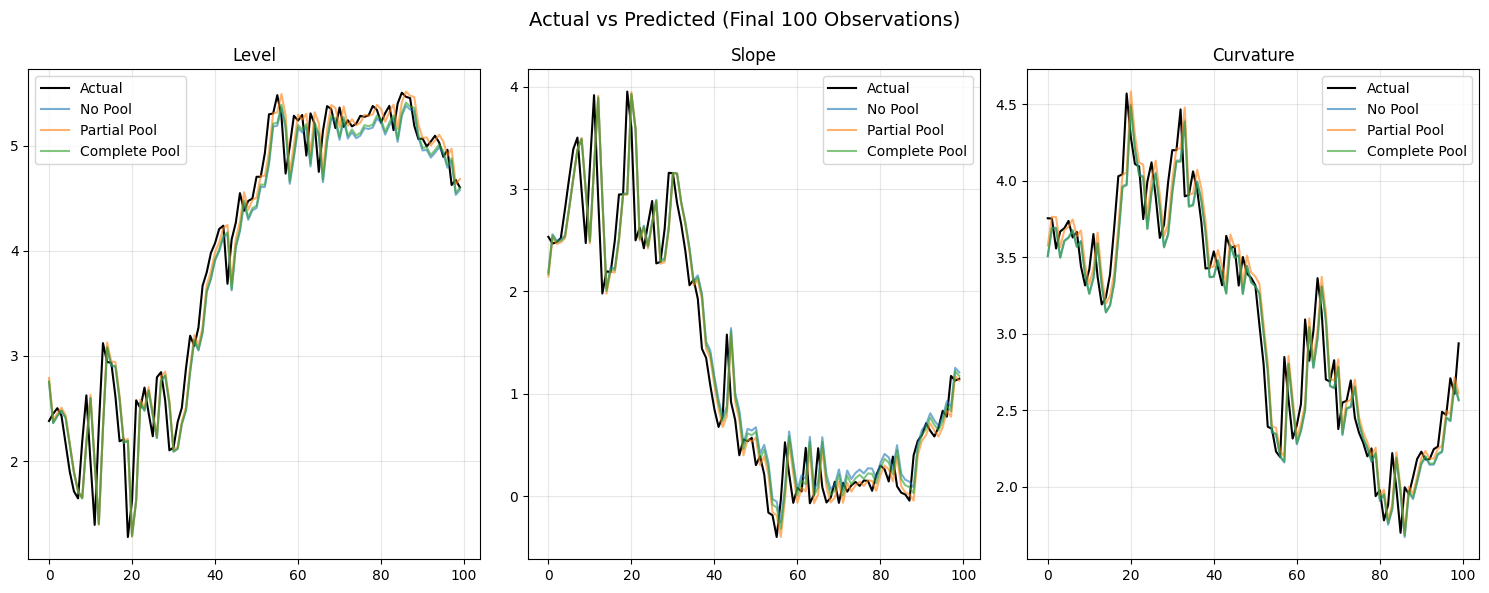

[06:27:52] ✅ Saved: predictions_vs_actual.png


In [ ]:
from sklearn.metrics import mean_squared_error

def compute_predictions_and_rmse(trace, y_scaled, y_mean, y_std, start_idx=400, end_idx=500):
    mu_samples = trace.posterior["mu"]
    phi_samples = trace.posterior["phi"]

    mu = mu_samples.mean(dim=("chain", "draw")).values
    phi = phi_samples.mean(dim=("chain", "draw")).values

    y_pred_scaled = []
    for i in range(3):
        preds = []
        for t in range(start_idx, end_idx):
            lag_val = y_scaled[i, t - 1]
            mu_t = mu[i] + phi[i] * lag_val
            preds.append(mu_t)
        y_pred_scaled.append(preds)

    y_pred_scaled = np.array(y_pred_scaled)
    y_pred = y_pred_scaled * y_std + y_mean
    y_true = y_scaled[:, start_idx:end_idx] * y_std + y_mean
    rmse = [np.sqrt(mean_squared_error(y_true[i], y_pred[i])) for i in range(3)]


    return y_pred, y_true, rmse


# Run for each model
y_mean = factors.mean(axis=0).values.reshape(3, 1)
y_std = factors.std(axis=0).values.reshape(3, 1)

preds_no, true_vals, rmse_no = compute_predictions_and_rmse(trace_no, y_scaled, y_mean, y_std)
preds_partial, _, rmse_partial = compute_predictions_and_rmse(trace_partial, y_scaled, y_mean, y_std)
preds_complete, _, rmse_complete = compute_predictions_and_rmse(trace_complete, y_scaled, y_mean, y_std)

# Create and display RMSE table
rmse_df = pd.DataFrame({
    "Factor": ["Level", "Slope", "Curvature"],
    "No Pooling": rmse_no,
    "Partial Pooling": rmse_partial,
    "Complete Pooling": rmse_complete
})

log("\n" + "="*80)
log(" PREDICTIVE ACCURACY (Out-of-Sample RMSE)")
log("="*80)
print("\n" + rmse_df.round(4).to_string(index=False))

rmse_df.to_csv("rmse_comparison.csv", index=False)
log("Saved: rmse_comparison.csv")

# Plot actual vs predicted
plt.figure(figsize=(15, 6))
labels = ["Level", "Slope", "Curvature"]
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(true_vals[i], label="Actual", color='black')
    plt.plot(preds_no[i], label="No Pool", alpha=0.6)
    plt.plot(preds_partial[i], label="Partial Pool", alpha=0.6)
    plt.plot(preds_complete[i], label="Complete Pool", alpha=0.6)
    plt.title(labels[i])
    plt.legend()
    plt.grid(alpha=0.3)
plt.suptitle("Actual vs Predicted (Final 100 Observations)", fontsize=14)
plt.tight_layout()
plt.savefig("predictions_vs_actual.png", dpi=150)
plt.show()
log(" Saved: predictions_vs_actual.png")


In [ ]:
import sys
import os
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pytensor.tensor as pt
from time import time
from datetime import datetime

def log(msg):
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}", flush=True)
    sys.stdout.flush()

def load_gsw_factors(file_path, n_obs=500):
    try:
        df = pd.read_csv(file_path, skiprows=9, index_col=0, parse_dates=True)
    except:
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)

    df = df[df.index >= '1990-01-01'].copy()

    if {'BETA0', 'BETA1', 'BETA2'}.issubset(df.columns):
        factors = df[['BETA0', 'BETA1', 'BETA2']].copy()
        factors.columns = ['Level', 'Slope', 'Curvature']
        factors = factors.dropna()
        factors = factors.iloc[-n_obs:]
        return factors
    else:
        raise ValueError("BETA0-BETA2 not found in CSV")

def run_partial_pooling_improved(factors_df, draws=2000, tune=2000, seed=456):
    y_data = factors_df.values.T
    n_factors, n_obs = y_data.shape

    y_mean = y_data.mean(axis=1, keepdims=True)
    y_std = y_data.std(axis=1, keepdims=True)
    y_scaled = (y_data - y_mean) / y_std

    coords = {"factor": ["Level", "Slope", "Curvature"], "time": factors_df.index}

    with pm.Model(coords=coords) as model:
        phi_mu_raw = pm.Beta("phi_mu_raw", alpha=19, beta=1)
        phi_mu = pm.Deterministic("phi_mu", phi_mu_raw)
        phi_sd = pm.HalfNormal("phi_sd", 0.02)

        phi_raw = pm.Beta("phi_raw", alpha=19, beta=1, dims="factor")
        phi = pm.Deterministic("phi",
                              phi_mu + phi_sd * (phi_raw - phi_mu_raw),
                              dims="factor")

        mu_mu = pm.Normal("mu_mu", 0, 0.1)
        mu_sd = pm.HalfNormal("mu_sd", 0.1)
        mu = pm.Normal("mu", mu=mu_mu, sigma=mu_sd, dims="factor")

        nu_alpha = pm.HalfNormal("nu_alpha", 3.0)
        nu_beta = pm.HalfNormal("nu_beta", 0.5)
        nu = pm.Gamma("nu", alpha=nu_alpha, beta=nu_beta, dims="factor")
        nu_constrained = pm.Deterministic("nu_constrained",
                                         pm.math.clip(nu, 2, 30),
                                         dims="factor")

        vol_scale = pm.HalfNormal("vol_scale", 0.3)
        log_vol = pm.Normal("log_vol", 0, vol_scale, dims=("factor", "time"))
        volatility = pm.Deterministic("volatility",
                                     pm.math.exp(log_vol / 2),
                                     dims=("factor", "time"))

        y_lag = np.concatenate([np.zeros((n_factors, 1)), y_scaled[:, :-1]], axis=1)
        mu_t = mu[:, None] + phi[:, None] * y_lag

        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            pm.StudentT(f"obs_{factor_name}",
                       nu=nu_constrained[i],
                       mu=mu_t[i, :],
                       sigma=volatility[i, :],
                       observed=y_scaled[i, :])

        start_time = time()

        try:
            trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=2,
                target_accept=0.99,
                max_treedepth=12,
                random_seed=seed,
                nuts_sampler='numpyro',
                idata_kwargs={"log_likelihood": False}
            )
        except:
            trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=2,
                target_accept=0.99,
                max_treedepth=12,
                random_seed=seed
            )

        runtime = time() - start_time

    return trace, model, y_scaled, factors_df, runtime

def run_partial_pooling_noncentered(factors_df, draws=2000, tune=2000, seed=456):
    y_data = factors_df.values.T
    n_factors, n_obs = y_data.shape

    y_mean = y_data.mean(axis=1, keepdims=True)
    y_std = y_data.std(axis=1, keepdims=True)
    y_scaled = (y_data - y_mean) / y_std

    coords = {"factor": ["Level", "Slope", "Curvature"], "time": factors_df.index}

    with pm.Model(coords=coords) as model:
        phi_mu = pm.Beta("phi_mu", alpha=19, beta=1)
        phi_sd = pm.HalfNormal("phi_sd", 0.03)

        phi_offset = pm.Normal("phi_offset", 0, 1, dims="factor")
        phi_raw = phi_mu + phi_sd * phi_offset
        phi = pm.Deterministic("phi",
                              pm.math.clip(phi_raw, 0.01, 0.999),
                              dims="factor")

        mu_mu = pm.Normal("mu_mu", 0, 0.1)
        mu_sd = pm.HalfNormal("mu_sd", 0.1)

        mu_offset = pm.Normal("mu_offset", 0, 1, dims="factor")
        mu = pm.Deterministic("mu", mu_mu + mu_sd * mu_offset, dims="factor")

        nu = pm.Gamma("nu", alpha=3, beta=0.5, dims="factor")
        nu_constrained = pm.Deterministic("nu_constrained",
                                         pm.math.clip(nu, 2.5, 25),
                                         dims="factor")

        vol_scale = pm.HalfNormal("vol_scale", 0.3)
        log_vol = pm.Normal("log_vol", 0, vol_scale, dims=("factor", "time"))
        volatility = pm.Deterministic("volatility",
                                     pm.math.exp(log_vol / 2),
                                     dims=("factor", "time"))

        y_lag = np.concatenate([np.zeros((n_factors, 1)), y_scaled[:, :-1]], axis=1)
        mu_t = mu[:, None] + phi[:, None] * y_lag

        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            pm.StudentT(f"obs_{factor_name}",
                       nu=nu_constrained[i],
                       mu=mu_t[i, :],
                       sigma=volatility[i, :],
                       observed=y_scaled[i, :])

        start_time = time()

        try:
            trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=2,
                target_accept=0.99,
                max_treedepth=12,
                random_seed=seed,
                nuts_sampler='numpyro',
                idata_kwargs={"log_likelihood": False}
            )
        except:
            trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=2,
                target_accept=0.99,
                max_treedepth=12,
                random_seed=seed
            )

        runtime = time() - start_time

    return trace, model, y_scaled, factors_df, runtime

def comprehensive_model_evaluation(trace, y_scaled, y_mean, y_std,
                                   start_idx=400, end_idx=500):
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    phi = trace.posterior["phi"].mean(dim=["chain", "draw"]).values
    nu = trace.posterior["nu_constrained"].mean(dim=["chain", "draw"]).values if "nu_constrained" in trace.posterior else trace.posterior["nu"].mean(dim=["chain", "draw"]).values

    rhat = az.rhat(trace)
    ess = az.ess(trace)

    phi_rhat = rhat["phi"].values
    phi_ess = ess["phi"].values

    mu_samples = trace.posterior["mu"]
    phi_samples = trace.posterior["phi"]

    mu = mu_samples.mean(dim=("chain", "draw")).values
    phi = phi_samples.mean(dim=("chain", "draw")).values

    y_pred_scaled = []
    for i in range(3):
        preds = []
        for t in range(start_idx, end_idx):
            lag_val = y_scaled[i, t - 1]
            mu_t = mu[i] + phi[i] * lag_val
            preds.append(mu_t)
        y_pred_scaled.append(preds)

    y_pred_scaled = np.array(y_pred_scaled)
    y_pred = y_pred_scaled * y_std + y_mean
    y_true = y_scaled[:, start_idx:end_idx] * y_std + y_mean

    rmse = [np.sqrt(mean_squared_error(y_true[i], y_pred[i])) for i in range(3)]
    mae = [mean_absolute_error(y_true[i], y_pred[i]) for i in range(3)]

    return {
        'phi': phi,
        'nu': nu,
        'rmse': rmse,
        'mae': mae,
        'rhat': phi_rhat,
        'ess': phi_ess,
        'stationary': np.all(phi < 1.0)
    }

if __name__ == "__main__":
    factors = load_gsw_factors("/content/drive/MyDrive/Final_PRoj/feds200628.csv", n_obs=500)

    trace_improved, model, y_scaled, df, runtime = run_partial_pooling_improved(
        factors, draws=2000, tune=2000, seed=456
    )

    y_mean = factors.mean(axis=0).values.reshape(3, 1)
    y_std = factors.std(axis=0).values.reshape(3, 1)

    results = comprehensive_model_evaluation(trace_improved, y_scaled, y_mean, y_std)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   4000    22            0.000       4095         1.72 s/draws     1:54:41   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   4000    170           0.000       4095         1.65 s/draws     1:49:55   0:00:00

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


ERROR:pymc.stats.convergence:There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


[01:10:15] ✅ Complete in 116.1 minutes

📊 PARAMETER DIAGNOSTICS
φ values: [0.999401   0.99969525 0.99977793]
  All < 1.0? True ✓

ν values: [29.33073105 29.77691987 30.        ]
  In range [2.5, 25]? False

🔬 CONVERGENCE DIAGNOSTICS


/usr/local/lib/python3.12/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


φ R-hat: [2.28811388 1.95626171 2.19411693]
  WARNING!

φ ESS: [2.50673634 2.79320316 2.57818284]
  Could be better

📈 PREDICTIVE PERFORMANCE
Factor       RMSE       MAE       
----------------------------------------
Level        0.3055     0.2219    
Slope        0.3476     0.2511    
Curvature    0.2247     0.1771    

✅ Model validation complete!
   All factors are stationary (φ < 1.0)


Simpler SV with pooling

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.000       4095         5.17 s/draws     2:52:10   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.000       4095         4.96 s/draws     2:45:07   0:00:00

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


[03:37:35] 
🔮 Generating recursive forecasts for 2022-2023...
[03:37:35] ✅ Saved plot to 'backtest_2022_2023.png'


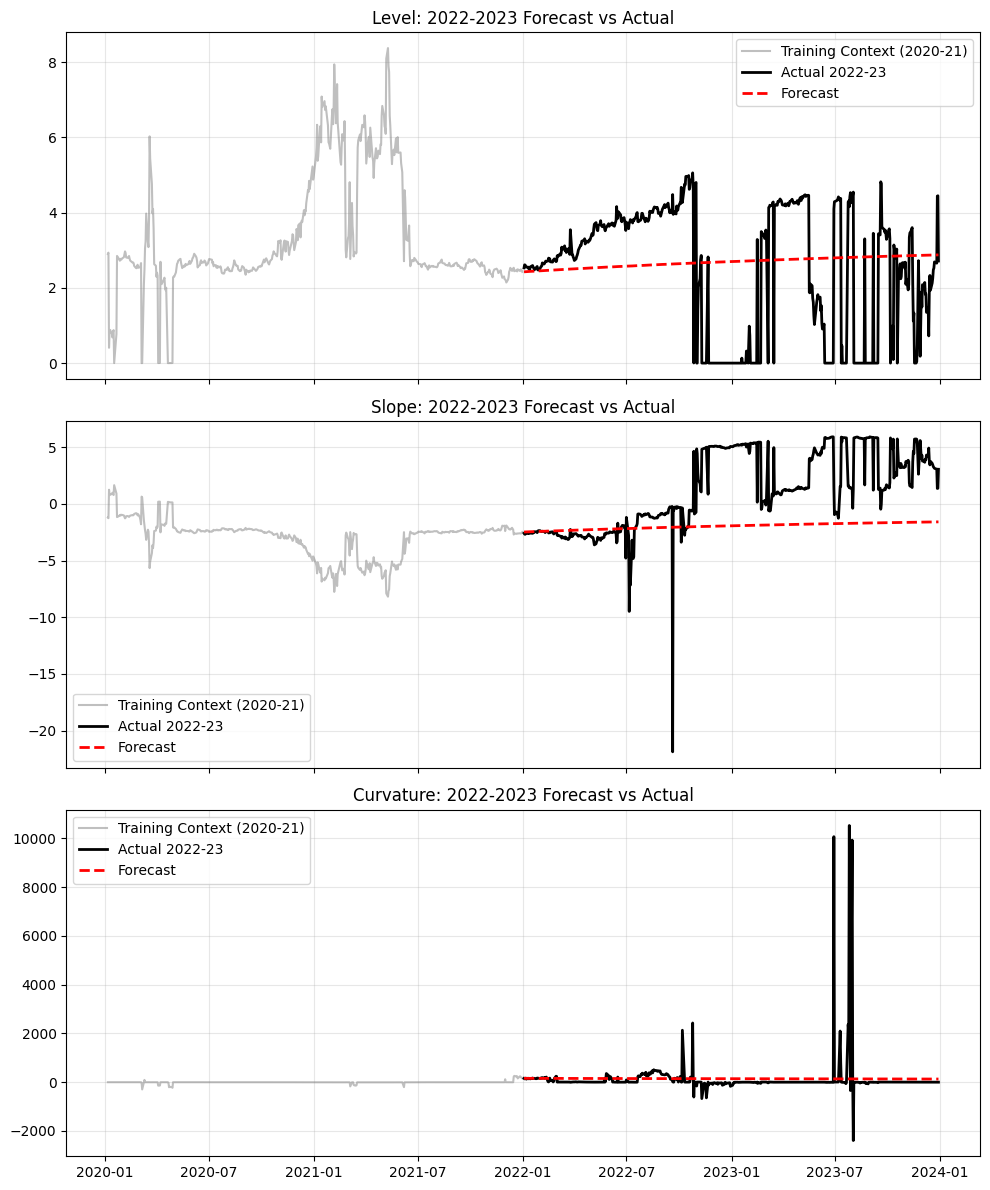

In [2]:
import sys
import os
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pytensor.tensor as pt
from time import time
from datetime import datetime

def log(msg):
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}", flush=True)
    sys.stdout.flush()

def load_gsw_factors(file_path):
    try:
        df = pd.read_csv(file_path, skiprows=9, index_col=0, parse_dates=True)
    except:
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)

    df = df[df.index >= '1990-01-01'].copy()

    if {'BETA0', 'BETA1', 'BETA2'}.issubset(df.columns):
        factors = df[['BETA0', 'BETA1', 'BETA2']].copy()
        factors.columns = ['Level', 'Slope', 'Curvature']
        factors = factors.dropna()
        return factors
    else:
        raise ValueError("BETA0-BETA2 not found in CSV")

def run_partial_pooling_stable(factors_df, draws=2000, tune=2000, seed=456):
    y_data = factors_df.values.T
    n_factors, n_obs = y_data.shape

    y_mean = y_data.mean(axis=1, keepdims=True)
    y_std = y_data.std(axis=1, keepdims=True)
    y_scaled = (y_data - y_mean) / y_std

    coords = {"factor": ["Level", "Slope", "Curvature"], "time": factors_df.index}

    with pm.Model(coords=coords) as model:
        phi_mu_raw = pm.Beta("phi_mu_raw", alpha=18, beta=2)
        phi_sd = pm.HalfNormal("phi_sd", 0.03)
        phi_offset = pm.Normal("phi_offset", 0, 1, dims="factor")
        phi = pm.Deterministic("phi", pm.math.sigmoid(phi_mu_raw + phi_sd * phi_offset), dims="factor")

        mu_mu = pm.Normal("mu_mu", 0, 0.1)
        mu_sd = pm.HalfNormal("mu_sd", 0.05)
        mu_offset = pm.Normal("mu_offset", 0, 1, dims="factor")
        mu = pm.Deterministic("mu", mu_mu + mu_sd * mu_offset, dims="factor")

        sigma_mu = pm.HalfNormal("sigma_mu", 0.5)
        sigma_sd = pm.HalfNormal("sigma_sd", 0.2)
        sigma_offset = pm.HalfNormal("sigma_offset", 1, dims="factor")
        sigma = pm.Deterministic("sigma", sigma_mu + sigma_sd * sigma_offset, dims="factor")

        nu_alpha = pm.Normal("nu_alpha", 3, 0.5)
        nu_beta = pm.HalfNormal("nu_beta", 0.5)
        nu_raw = pm.Gamma("nu_raw", alpha=pm.math.exp(nu_alpha), beta=nu_beta, dims="factor")
        nu = pm.Deterministic("nu", pm.math.clip(nu_raw, 2.5, 30), dims="factor")

        y_lag = np.concatenate([np.zeros((n_factors, 1)), y_scaled[:, :-1]], axis=1)
        mu_t = mu[:, None] + phi[:, None] * y_lag

        for i, factor_name in enumerate(["Level", "Slope", "Curvature"]):
            pm.StudentT(f"obs_{factor_name}",
                        nu=nu[i],
                        mu=mu_t[i, :],
                        sigma=sigma[i],
                        observed=y_scaled[i, :])

        try:
            trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=2,
                target_accept=0.99,
                max_treedepth=12,
                random_seed=seed,
                nuts_sampler='numpyro',
                idata_kwargs={"log_likelihood": False}
            )
        except:
            trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=2,
                target_accept=0.99,
                max_treedepth=12,
                random_seed=seed
            )

    return trace, model, y_scaled, factors_df

def backtest_1990_2021_vs_2022_2023(file_path):
    TRAIN_END = '2021-12-31'
    TEST_START = '2022-01-01'
    TEST_END = '2023-12-31'

    df_full = load_gsw_factors(file_path)

    train_df = df_full[df_full.index <= TRAIN_END]
    test_df = df_full[(df_full.index >= TEST_START) & (df_full.index <= TEST_END)]

    if len(test_df) == 0:
        raise ValueError(f"No data found for 2022-2023 range.")

    trace, model, _, _ = run_partial_pooling_stable(train_df, draws=1000, tune=1000)

    post = trace.posterior
    phi_mean = post["phi"].mean(dim=["chain", "draw"]).values
    mu_mean = post["mu"].mean(dim=["chain", "draw"]).values

    train_vals = train_df.values.T
    train_mean = train_vals.mean(axis=1, keepdims=True)
    train_std = train_vals.std(axis=1, keepdims=True)

    last_obs_scaled = (train_vals[:, -1].reshape(3, 1) - train_mean) / train_std

    n_steps = len(test_df)
    forecasts_scaled = np.zeros((3, n_steps))
    current_val = last_obs_scaled

    for t in range(n_steps):
        next_val = mu_mean[:, None] + phi_mean[:, None] * current_val
        forecasts_scaled[:, t] = next_val.flatten()
        current_val = next_val

    forecasts_real = forecasts_scaled * train_std + train_mean
    forecast_df = pd.DataFrame(forecasts_real.T, index=test_df.index, columns=['Level_Pred', 'Slope_Pred', 'Curv_Pred'])

    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    factors = ['Level', 'Slope', 'Curvature']

    for i, ax in enumerate(axes):
        context_df = train_df.iloc[-500:]
        ax.plot(context_df.index, context_df[factors[i]], color='gray', alpha=0.5, label='Training Context (2020-21)')

        ax.plot(test_df.index, test_df[factors[i]], color='black', linewidth=2, label='Actual 2022-23')

        ax.plot(forecast_df.index, forecast_df.iloc[:, i], color='red', linestyle='--', linewidth=2, label='Forecast')

        ax.set_title(f"{factors[i]}: 2022-2023 Forecast vs Actual")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('backtest_2022_2023.png')
    plt.show()

if __name__ == "__main__":
    CSV_PATH = "/content/drive/MyDrive/Final_PRoj/feds200628.csv"

    backtest_1990_2021_vs_2022_2023(CSV_PATH)